In [58]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

# Gradient Boosted Trees


In [10]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import processed_data_dir

dataset_version = 'v4.1'

input_dir = processed_data_dir / 'wide_datasets' / dataset_version

## Load Data

In [11]:
train_df = pd.read_csv(input_dir/'train.csv', index_col=0)
test_df = pd.read_csv(input_dir/'test.csv', index_col=0)

train_df.head()

,ndvi_mean_2017-01-01,ndvi_mean_2017-01-31,ndvi_mean_2017-02-10,ndvi_mean_2017-03-12,ndvi_mean_2017-03-22,ndvi_mean_2017-05-31,ndvi_mean_2017-06-20,ndvi_mean_2017-07-10,ndvi_mean_2017-07-15,ndvi_mean_2017-08-04,...,band_12_std_2017-02-10,band_12_std_2017-03-12,band_12_std_2017-03-22,band_12_std_2017-05-31,band_12_std_2017-06-20,band_12_std_2017-07-10,band_12_std_2017-07-15,band_12_std_2017-08-04,band_12_std_2017-08-19,y
farm_id,,,,,,,,,,,,,,,,,,,,,
1,0.671766,0.718396,0.746055,0.668629,0.659258,0.247449,0.234662,0.246357,0.278753,0.217553,...,533.618506,490.728297,455.879587,815.750994,897.448315,830.929140,918.824975,716.475023,977.449066,Vineyard
2,0.682275,0.702713,0.802193,0.457887,0.497860,0.712684,0.671382,0.625462,0.666805,0.380044,...,464.616491,736.054274,499.812831,439.249060,522.862134,541.199592,554.839571,655.437723,842.016789,Pecan
3,0.528756,0.657075,0.668956,0.670401,0.643311,0.532119,0.361842,0.261191,0.274244,0.177425,...,458.616322,364.423058,369.769554,452.374060,590.377680,640.320051,676.874166,537.452323,866.403363,Vineyard
4,0.674225,0.746993,0.747719,0.723733,0.632834,0.376561,0.317186,0.271709,0.297141,0.166450,...,434.587467,342.331664,381.795574,615.638041,674.717005,692.681227,733.771024,744.607236,904.862080,Vineyard
7,0.699023,0.786059,0.808145,0.676815,0.682761,0.544508,0.508780,0.478193,0.517747,0.391577,...,416.870414,511.503689,450.955994,510.101591,633.729514,648.671586,670.512631,599.020332,791.042767,Vineyard


In [12]:
from src.utils import read_shapefile

train_shp = read_shapefile('train')
test_shp = read_shapefile('test')

train_shp.head()

,Area,Subregion,Crop_Id_Ne,geometry,y
Field_Id,,,,,
1,0.915905,3,8,"POLYGON ((613924.3324000851 6793991.295069702,...",Vineyard
2,2.064410,3,6,"POLYGON ((614404.0717397591 6794020.579634549,...",Pecan
3,1.080300,3,8,"POLYGON ((614320.2146632321 6793964.242091182,...",Vineyard
4,1.316190,3,8,"POLYGON ((614560.5326844405 6794002.249461887,...",Vineyard
7,5.529220,3,8,"POLYGON ((614596.6564746551 6794269.865436315,...",Vineyard


In [13]:
train_df = train_df.join(train_shp[['Area','Subregion']], on='farm_id')
test_df = test_df.join(test_shp[['Area','Subregion']],on='farm_id')
test_df.head()

,ndvi_mean_2017-01-01,ndvi_mean_2017-01-31,ndvi_mean_2017-02-10,ndvi_mean_2017-03-12,ndvi_mean_2017-03-22,ndvi_mean_2017-05-31,ndvi_mean_2017-06-20,ndvi_mean_2017-07-10,ndvi_mean_2017-07-15,ndvi_mean_2017-08-04,...,band_12_std_2017-03-12,band_12_std_2017-03-22,band_12_std_2017-05-31,band_12_std_2017-06-20,band_12_std_2017-07-10,band_12_std_2017-07-15,band_12_std_2017-08-04,band_12_std_2017-08-19,Area,Subregion
farm_id,,,,,,,,,,,,,,,,,,,,,
5,0.689752,0.773126,0.774520,0.720137,0.613666,0.436720,0.376625,0.345716,0.381350,0.227211,...,374.467666,395.884719,560.153703,582.647141,629.548042,655.616694,703.637295,855.835634,1.322590,3
6,0.694655,0.789114,0.787505,0.753942,0.652290,0.418973,0.375680,0.333532,0.363635,0.227089,...,329.974868,368.035198,631.064734,709.116663,723.393115,757.971468,766.951496,970.486262,0.955864,3
10,0.669926,0.740941,0.764852,0.654301,0.628696,0.393253,0.350072,0.343705,0.386512,0.330026,...,484.990029,468.553384,632.495559,785.144942,787.349056,818.872934,662.566617,902.324329,11.509800,3
18,0.601200,0.667428,0.675655,0.624135,0.600976,0.300465,0.262714,0.249589,0.277210,0.242686,...,460.445584,449.817249,782.989772,876.720798,862.770297,896.237658,872.445829,1082.675941,2.697520,3
23,0.607554,0.634566,0.634429,0.666931,0.637391,0.304994,0.232380,0.206135,0.229459,0.209351,...,300.595452,281.677058,575.804838,670.999797,663.540046,698.941489,729.383007,876.495971,4.238030,3


## Define model static params

* 9 classes
* multi class log loss

In [25]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from xgboost.sklearn import XGBClassifier

X = train_df.drop('y', axis=1)
y = train_df.y

static_params = {
        'objective': 'multi:softprob',
        'num_class': 9,
        'eval_metric': 'mlogloss',
        'seed': 2019,
}

def get_xgb(**params):
    
    xgb_params = {**static_params, **params}

    model = XGBClassifier(**xgb_params)

    return model

## Either: HPO or Skip to found best params below

### Search for hyper parameters

In [78]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold

from IPython.display import clear_output

class ConvergencePlotCallback(object):
    def __init__(self, figsize=(12,8)):
        self.fig = plt.figure(figsize=figsize)

    def __call__(self, res):
        clear_output(wait=True)
        plot_convergence(res)
        plt.show()
        
skf = StratifiedKFold(n_splits=3)
plot_callback = ConvergencePlotCallback(figsize=(12,8));

space = [
    Integer(1, 21, name='max_depth'),
    Real(1e-5, 0.1, "log-uniform", name='learning_rate'),
    Integer(1, 10, name='min_child_weight'),
    Real(1e-5, 10, "log-uniform", name='gamma'),
    Real(0.1, 1.0, "uniform", name="subsample"),
    Real(0.1, 1.0, "uniform", name='colsample_bytree'),
    Real(1e-6, 100, "log-uniform", name="reg_alpha")
]

@use_named_args(space)
def objective(**params):
    
    new_params = {**static_params}
    new_params.update(**params)
    
    model = XGBClassifier(**new_params)
    
    score = -np.mean(cross_val_score(model, X, y, cv=skf, n_jobs=-1, scoring='neg_log_loss'))
    
    return score

def to_named_params(params, space=space):
    return({dimension.name: param for dimension, param in zip(space, params)})

<Figure size 864x576 with 0 Axes>

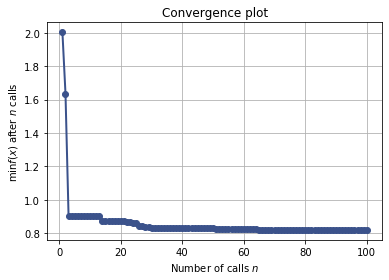

In [79]:
gp_results = gp_minimize(objective, space, n_calls=100, random_state=2019, callback=[plot_callback], n_jobs=-1)

In [97]:
from pprint import pprint

best_params = to_named_params(gp_results.x)
opt_params = {**static_params, **best_params}

print('Best params:')
pprint(best_params)

Best params:
{'colsample_bytree': 0.33475729690415135,
 'gamma': 0.001,
 'learning_rate': 0.0682585781151064,
 'max_depth': 13,
 'min_child_weight': 5,
 'reg_alpha': 1e-05,
 'subsample': 0.781029705398128}


# Skip HPO

If you want to skip HPO, use these params:

In [23]:
from pprint import pprint

best_params = {'colsample_bytree': 0.33475729690415135,
 'gamma': 0.001,
 'learning_rate': 0.0682585781151064,
 'max_depth': 13,
 'min_child_weight': 5,
 'reg_alpha': 1e-05,
 'subsample': 0.781029705398128}

opt_params = {**static_params, **best_params}

print('Best params:')
pprint(opt_params)

Best params:
{'colsample_bytree': 0.33475729690415135,
 'eval_metric': 'mlogloss',
 'gamma': 0.001,
 'learning_rate': 0.0682585781151064,
 'max_depth': 13,
 'min_child_weight': 5,
 'num_class': 9,
 'objective': 'multi:softprob',
 'reg_alpha': 1e-05,
 'seed': 2019,
 'subsample': 0.781029705398128}


## Inspect Model Performance

In [33]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix

from config import raw_data_dir

seed=2019

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

# Create validation set for permutation importance
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=seed)

# Fit model
best_model = get_xgb(**opt_params)
best_model.fit(X_train, y_train)

# Make predicitions ons validation set
val_preds = best_model.predict(X_val)

### Cross Validation Score

In [36]:
cv_scores = cross_val_score(get_xgb(**opt_params), X, y, scoring='neg_log_loss', n_jobs=-1, cv=StratifiedKFold(n_splits=3))

print('Cross validation score: {} (±{})'.format(np.mean(cv_scores)*-1, np.std(cv_scores)*-1))

Cross validation score: 0.8014464863951652 (±-0.009659329322318054)


### Classification Report

In [37]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(y_val, val_preds, labels=class_labels, output_dict=True))

/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Cotton,Dates,Grass,Lucern,Maize,Pecan,Vacant,Vineyard,"Vineyard & Pecan (""Intercrop"")",accuracy,macro avg,weighted avg
f1-score,0.781250,0.0,0.432432,0.824373,0.916667,0.440000,0.632353,0.850485,0.190476,0.783654,0.563115,0.761862
precision,0.862069,0.0,0.615385,0.793103,0.904110,0.846154,0.623188,0.782143,1.000000,0.783654,0.714017,0.787298
recall,0.714286,0.0,0.333333,0.858209,0.929577,0.297297,0.641791,0.931915,0.105263,0.783654,0.534630,0.783654
support,35.000000,2.0,24.000000,134.000000,71.000000,37.000000,67.000000,235.000000,19.000000,0.783654,624.000000,624.000000


### Confusion Matrix

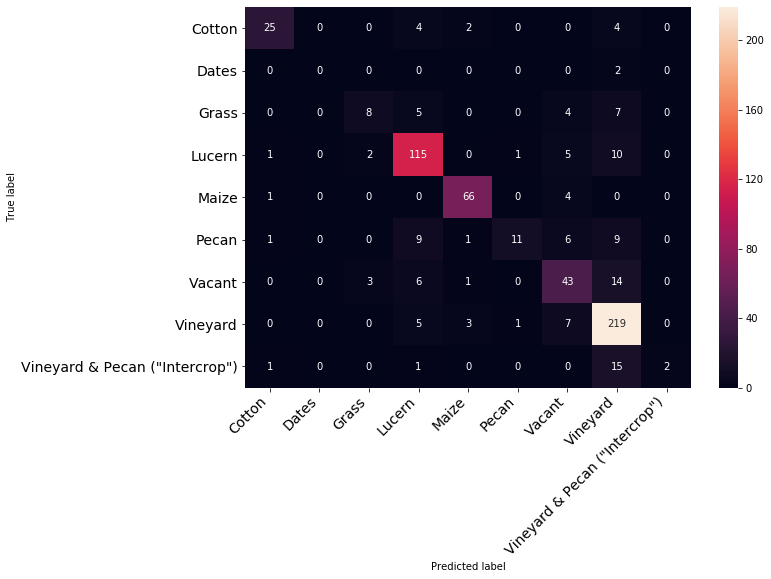

In [38]:
cm = confusion_matrix(y_val, val_preds)
print_confusion_matrix(cm, class_names=class_labels);

### Feature Importances

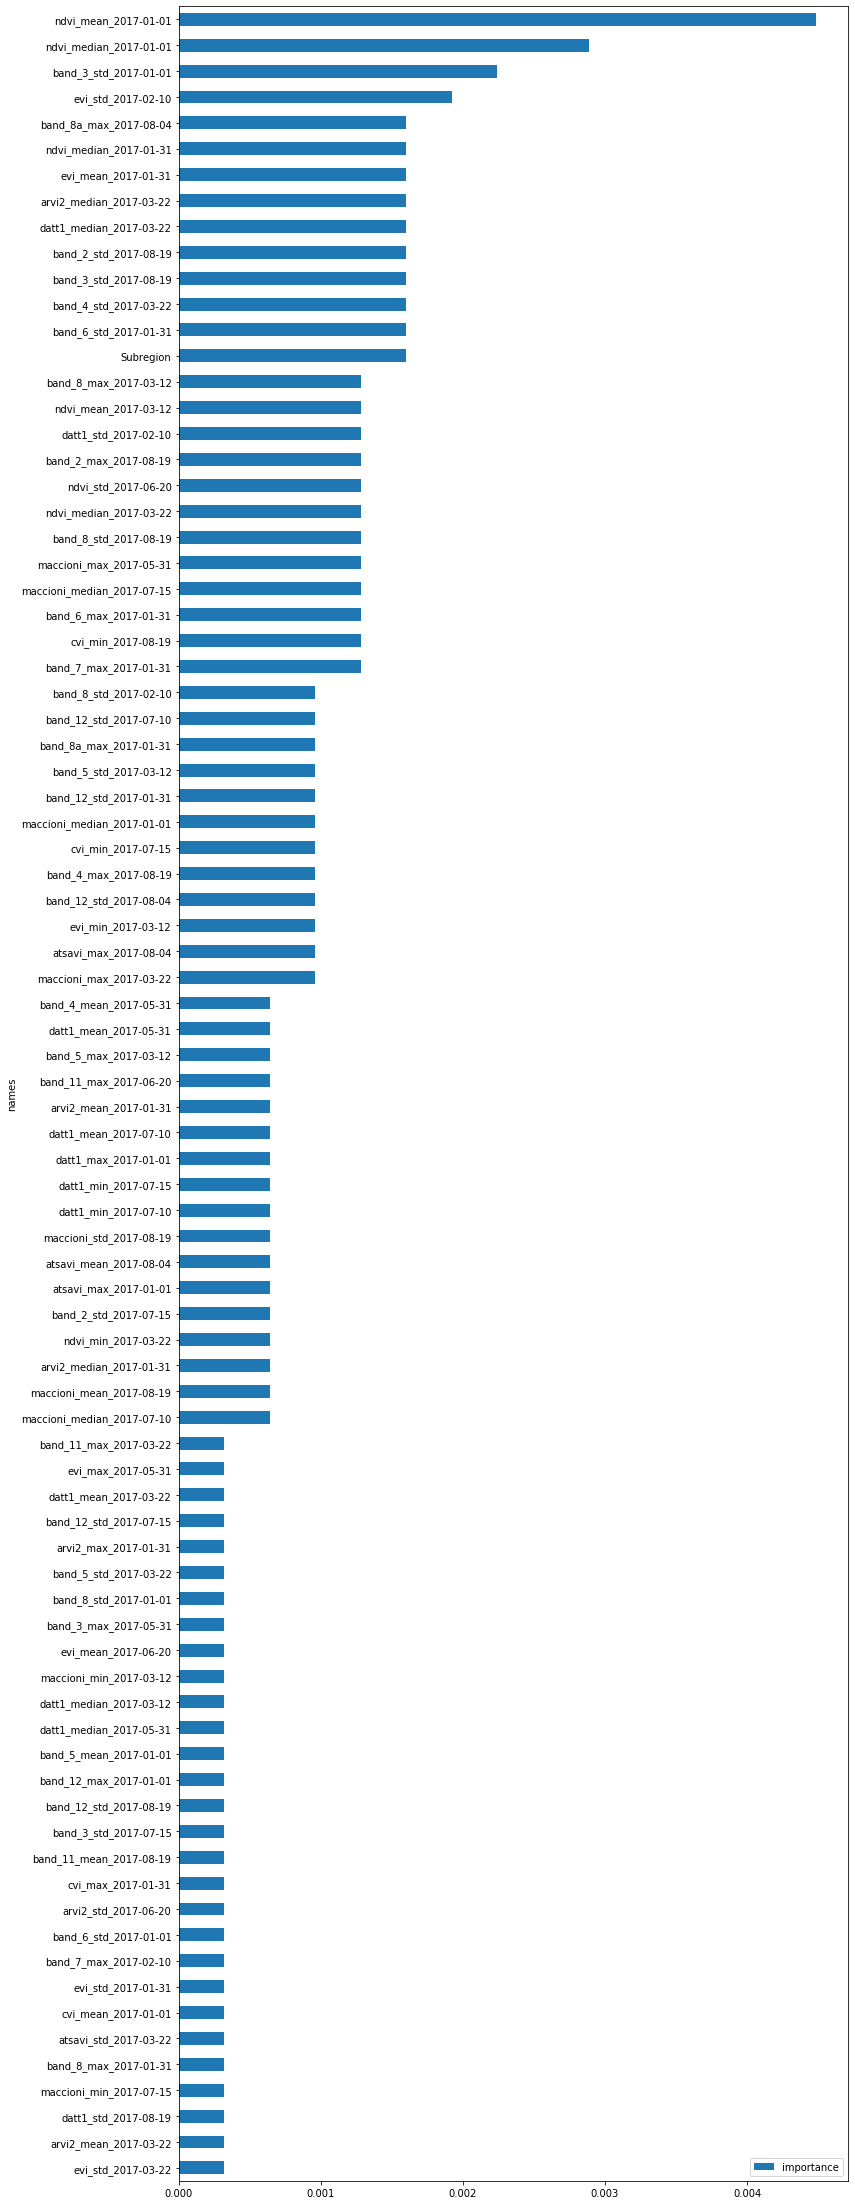

In [39]:
perm = PermutationImportance(best_model, random_state=seed).fit(X_val, y_val)

feat_imp = pd.DataFrame({'importance': perm.feature_importances_, 'names': X.columns}).sort_values(by='importance')

# Show only positive values
feat_imp = feat_imp[feat_imp.importance > 0]

plot = feat_imp.plot.barh(figsize=(12, 40), x='names')

## Make Submission

In [91]:
from config import raw_data_dir, subs_dir

def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')
    
    print(len(new_sub), len(ids_list))

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = best_model.predict_proba(test_df)
test_ids = test_df.index.to_list()

sub_df = make_sub(predictions, test_ids)
sub_df.head()

1074 1074


,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
5,0.019571,0.007821,0.036918,0.069737,0.008211,0.052741,0.018539,0.670766,0.115695
6,0.036144,0.007699,0.053368,0.044214,0.011272,0.069234,0.018883,0.697056,0.062130
10,0.002076,0.000885,0.002319,0.002613,0.001209,0.002967,0.001902,0.910606,0.075424
18,0.003895,0.001747,0.008335,0.003077,0.002935,0.006397,0.005739,0.933805,0.034070
23,0.004271,0.001846,0.006825,0.003447,0.003060,0.006533,0.008044,0.947135,0.018840


In [92]:
sub_df.to_csv(subs_dir / 'xgboost_data_v4_2.csv')